
Componentes encontrados: 75 (de 254)

Componente 1:
- Área: 26119.0 pixels
- Perímetro: 1125.00
- Solidez: 0.68
- Dimensão Fractal: 1.7023222432904694
- Lacunaridade (window=3): 1.9118914348952913
- Lacunaridade (window=5): 1.8886194520741202

Componente 2:
- Área: 93796.0 pixels
- Perímetro: 2097.72
- Solidez: 0.83
- Dimensão Fractal: 1.7993953349893423
- Lacunaridade (window=3): 1.6365915070220705
- Lacunaridade (window=5): 1.6285803012227023

Componente 3:
- Área: 3395.0 pixels
- Perímetro: 385.16
- Solidez: 0.68
- Dimensão Fractal: 1.6370420690266878
- Lacunaridade (window=3): 2.2483015875051326
- Lacunaridade (window=5): 2.1728426247059667

Componente 4:
- Área: 774.0 pixels
- Perímetro: 126.08
- Solidez: 0.89
- Dimensão Fractal: 1.7227367433748473
- Lacunaridade (window=3): 1.5732238247559778
- Lacunaridade (window=5): 1.5158032208450385

Componente 5:
- Área: 77007.0 pixels
- Perímetro: 3534.31
- Solidez: 0.51
- Dimensão Fractal: 1.611072911692992
- Lacunaridade (window=3): 4.7

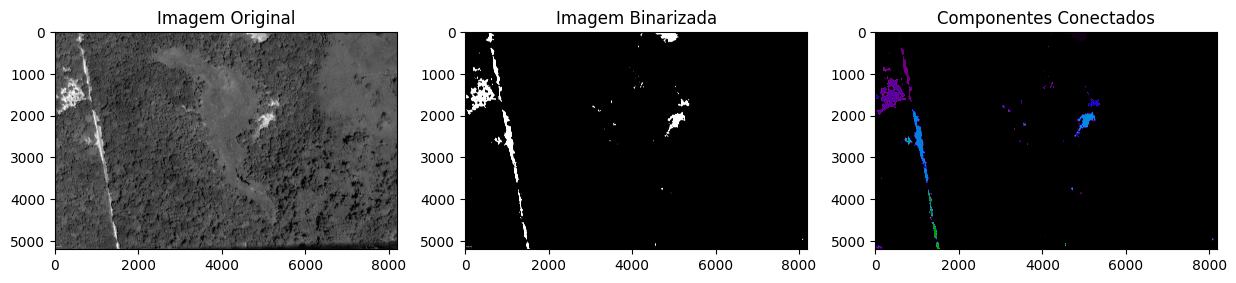

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from skimage import measure
from scipy.ndimage import label, uniform_filter

# 1. Função para cálculo de dimensão fractal com validações
def calc_fractal_dimension(region, min_box_size=1):
    """
    Calcula a dimensão fractal usando o método de box counting com:
    - Validação de tamanho mínimo da região
    - Controle de tamanhos de caixa válidos
    - Verificação de qualidade dos dados
    """
    img = region.image
    
    # Validação básica da região
    if np.sum(img) == 0 or min(img.shape) < 2:
        return np.nan
    
    # Geração de tamanhos de caixa
    max_box_size = min(img.shape) // 2
    box_sizes = []
    box_counts = []
    
    for box_size in range(min_box_size, max_box_size + 1):
        try:
            # Contagem adaptativa para diferentes tamanhos
            count = 0
            for i in range(0, img.shape[0], box_size):
                for j in range(0, img.shape[1], box_size):
                    if np.any(img[i:i+box_size, j:j+box_size]):
                        count += 1
            if count > 0:
                box_sizes.append(box_size)
                box_counts.append(count)
        except:
            continue
    
    # Validação dos dados para regressão
    if len(box_sizes) < 3:
        return np.nan
    
    # Cálculo da regressão com tratamento de erros
    try:
        coeffs = np.polyfit(np.log(box_sizes), np.log(box_counts), 1)
        return abs(coeffs[0])
    except:
        return np.nan

# 2. Função para cálculo de lacunaridade com múltiplas validações
def calc_lacunarity(region, window_size=3):
    """
    Calcula a lacunaridade para uma região binária com:
    - Verificação de tamanho mínimo da janela
    - Validação do formato da imagem
    - Controle de bordas
    """
    img = region.image.astype(float)
    
    # Validações iniciais
    if np.sum(img) == 0:
        return np.nan
    
    if window_size < 1 or any(ws > dim for ws, dim in zip([window_size]*2, img.shape)):
        return np.nan
    
    # Cálculo da massa nas janelas
    try:
        mass = uniform_filter(img, size=window_size, mode='constant') * (window_size**2)
        mean_mass = np.nanmean(mass)
        if mean_mass <= 0:
            return np.nan
        return np.nanmean(mass**2) / (mean_mass**2)
    except:
        return np.nan

# 3. Pipeline principal com tratamento completo
def analyze_image(image_path, threshold=128, min_component_size=10):
    # Carregamento e pré-processamento
    try:
        img = Image.open(image_path)
        gray = np.array(img.convert("L"))
        binary = (gray > threshold).astype(int)
    except Exception as e:
        print(f"Erro no pré-processamento: {e}")
        return
    
    # Análise de componentes conectados
    labeled, num_labels = label(binary)
    regions = measure.regionprops(labeled)
    
    # Filtro para componentes significativos
    valid_regions = [r for r in regions if r.area >= min_component_size]
    
    print(f"\nComponentes encontrados: {len(valid_regions)} (de {num_labels})")
    
    # Análise detalhada para os primeiros 5 componentes
    for i, region in enumerate(valid_regions[:5]):
        try:
            print(f"\nComponente {i+1}:")
            print(f"- Área: {region.area} pixels")
            print(f"- Perímetro: {region.perimeter:.2f}")
            print(f"- Solidez: {region.solidity:.2f}")
            
            fd = calc_fractal_dimension(region)
            print(f"- Dimensão Fractal: {fd if not np.isnan(fd) else 'Indeterminado'}")
            
            for ws in [3, 5]:
                lac = calc_lacunarity(region, ws)
                print(f"- Lacunaridade (window={ws}): {lac if not np.isnan(lac) else 'Indeterminado'}")
                
        except Exception as e:
            print(f"Erro na análise do componente {i+1}: {e}")

    # Visualização
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(gray, cmap='gray')
    ax[0].set_title("Imagem Original")
    ax[1].imshow(binary, cmap='gray')
    ax[1].set_title("Imagem Binarizada")
    ax[2].imshow(labeled, cmap='nipy_spectral')
    ax[2].set_title("Componentes Conectados")
    plt.show()

# 4. Execução do pipeline
if __name__ == "__main__":
    image_path = "a2.jpg"  # caminho
    analyze_image(image_path, threshold=128, min_component_size=50)